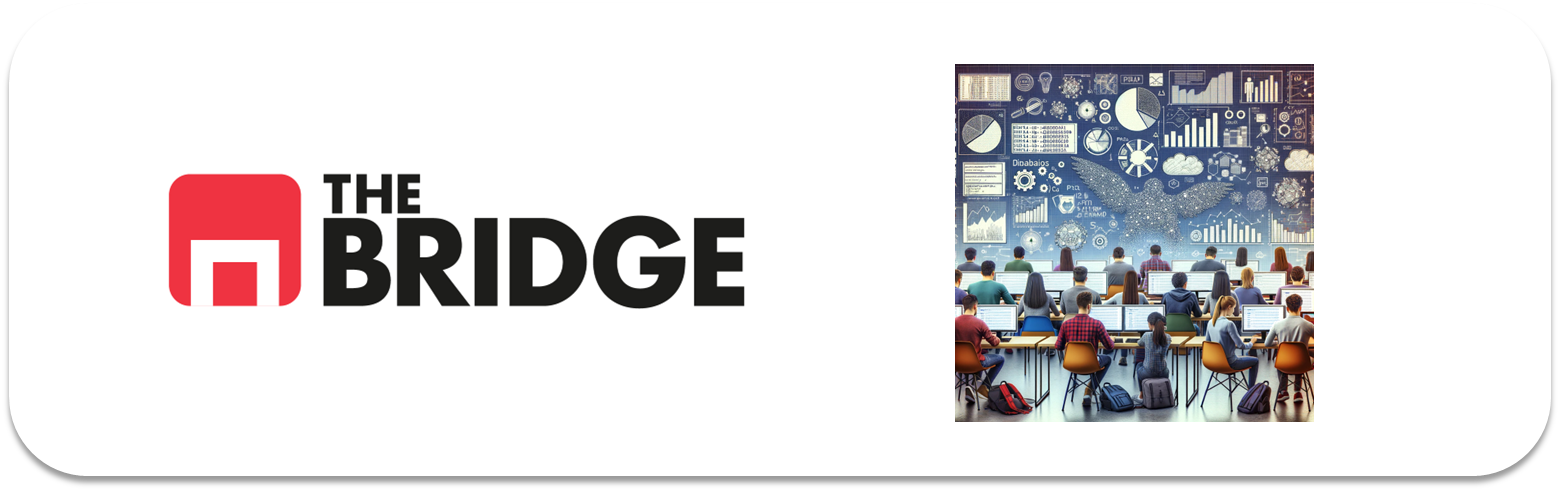

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:




In [74]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

df = pd.read_csv('data/titanic.csv')

df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [75]:
target = "survived"

In [76]:
#2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
excluidas = ["embark_town","alive","class", "adult_male"]

In [77]:
df["deck"] = df.deck.fillna("UNK")
features_base = [col for col in df.columns if col not in excluidas ]
features_base.remove("deck")
features_base_deck = [col for col in df.columns if col not in excluidas]

<Axes: xlabel='survived', ylabel='count'>

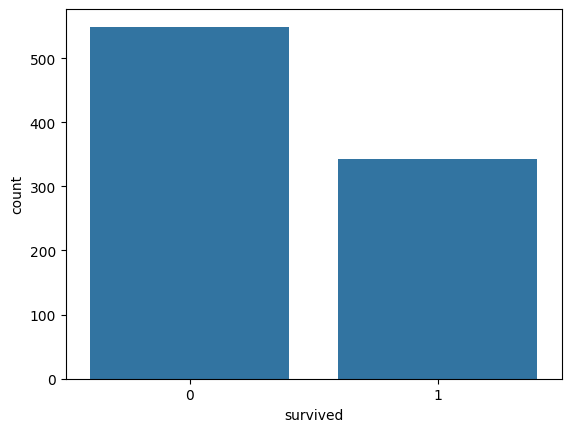

In [78]:
#3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
df_target = df.survived
df_target = pd.DataFrame(df_target)
sns.countplot(data= df_target, x= 'survived') 


In [79]:
df.loc[df["embarked"].isna(), "embarked"] = "S"

In [80]:
#5. Construye las parejas X,y de train y test.
train_set, test_set = train_test_split(df, test_size= 0.2, stratify= df["embarked"], random_state= 42)
train_set.embarked.value_counts(normalize= True)

embarked
S    0.724719
C    0.188202
Q    0.087079
Name: proportion, dtype: float64

In [81]:
test_set.embarked.value_counts(normalize= True)

embarked
S    0.726257
C    0.189944
Q    0.083799
Name: proportion, dtype: float64

In [82]:
#6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.



null_columns_train = train_set.columns[train_set.isnull().any()]


means_train = train_set[null_columns_train].mean()
modes_train = train_set[null_columns_train].mode().iloc[0] 


imputer_train = SimpleImputer(strategy='mean', missing_values=np.nan)
train_set[null_columns_train] = imputer_train.fit_transform(train_set[null_columns_train])


imputer_test = SimpleImputer(strategy='mean', missing_values=np.nan)
for col in null_columns_train:
    if col in test_set.columns:  
        if test_set[col].dtype == 'object': 
            test_set[col].fillna(modes_train[col], inplace=True)
        else:  # Imputar media para columnas numéricas
            test_set[col].fillna(means_train[col], inplace=True)


imputation_stats_test = {
    'means': means_train,
    'modes': modes_train
}




print("train_set después de la imputación:")
print(train_set.head())

print("\nX_test después de la imputación:")
print(test_set.head())


train_set después de la imputación:
     survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
838         1       3    male  32.0      0      0  56.4958        S   Third   
621         1       1    male  42.0      1      0  52.5542        S   First   
282         0       3    male  16.0      0      0   9.5000        S   Third   
275         1       1  female  63.0      1      0  77.9583        S   First   
217         0       2    male  42.0      1      0  27.0000        S  Second   

       who  adult_male deck  embark_town alive  alone  
838    man        True  UNK  Southampton   yes   True  
621    man        True    D  Southampton   yes  False  
282    man        True  UNK  Southampton    no   True  
275  woman       False    D  Southampton   yes  False  
217    man        True  UNK  Southampton    no  False  

X_test después de la imputación:
     survived  pclass   sex        age  sibsp  parch      fare embarked  \
395         0       3  male  22.000000      

C:\Users\pobla\AppData\Local\Temp\ipykernel_23604\822436234.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_set[col].fillna(means_train[col], inplace=True)


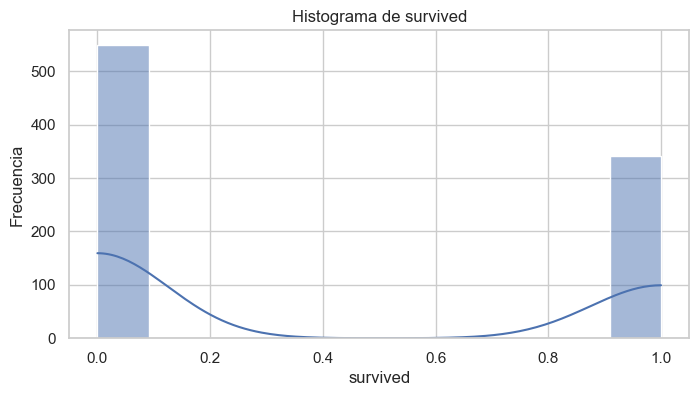

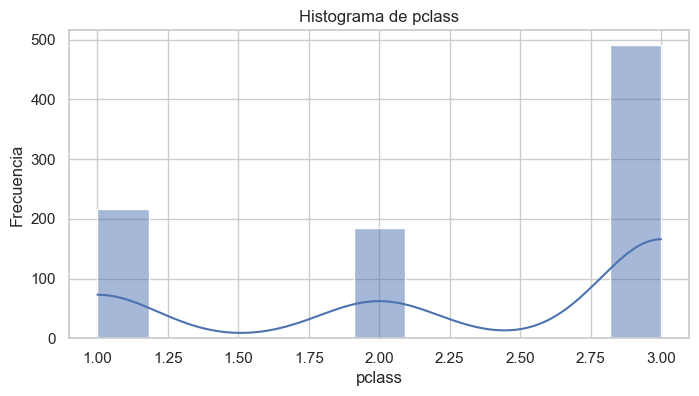

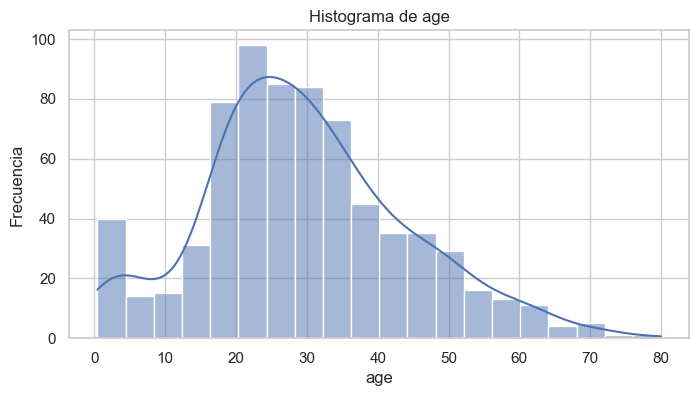

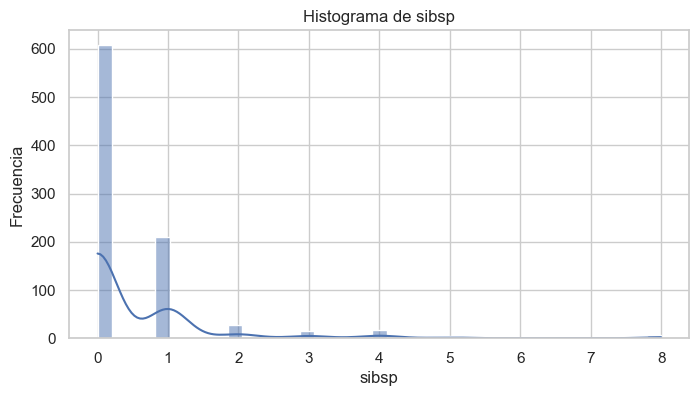

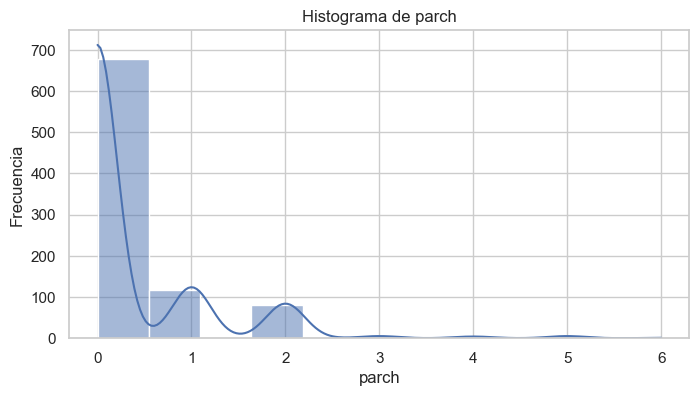

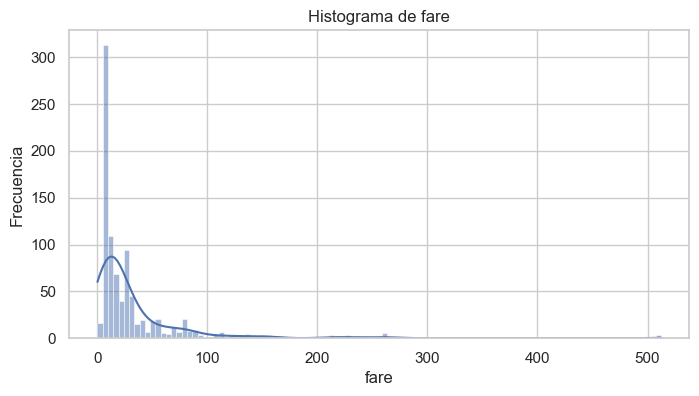

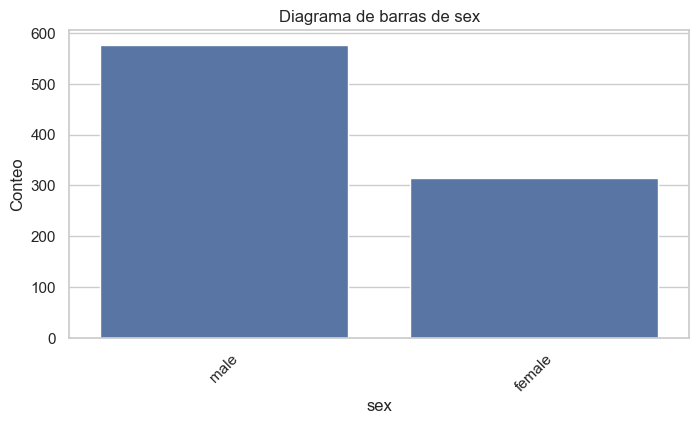

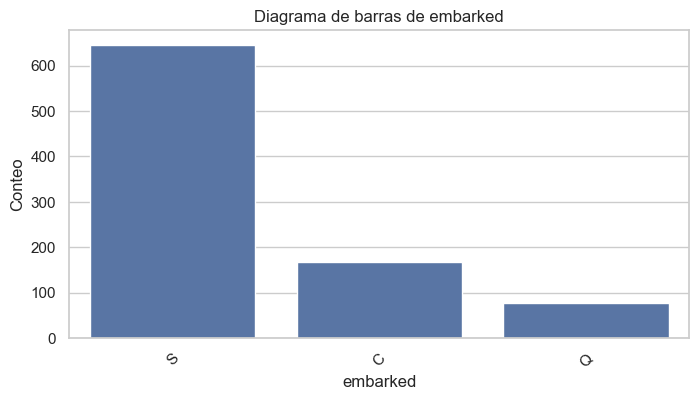

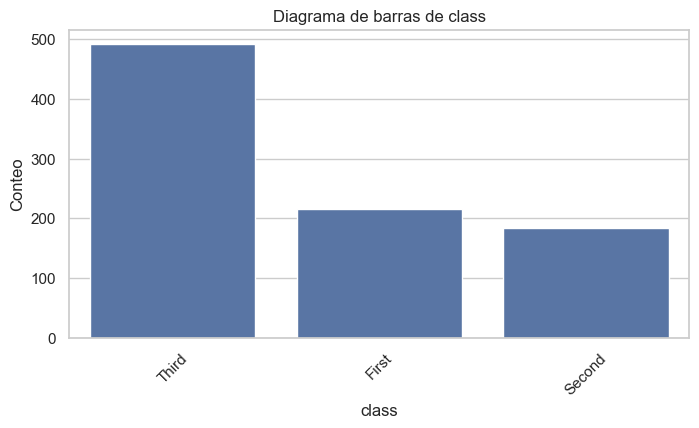

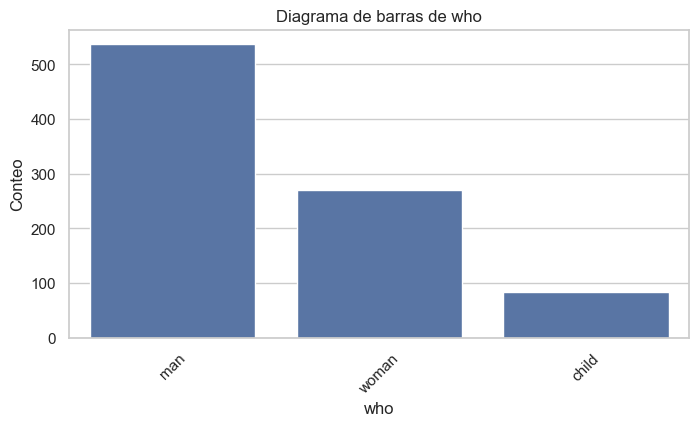

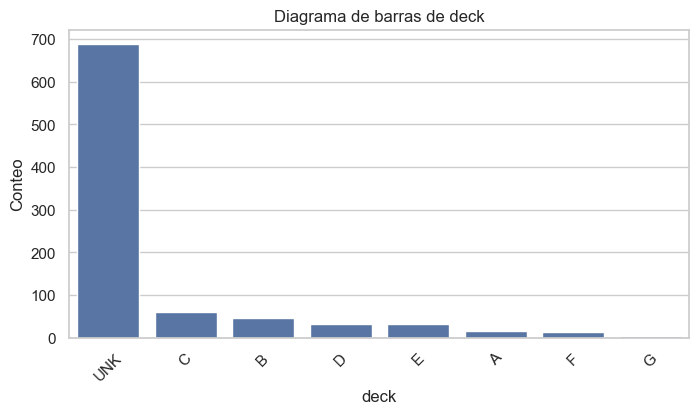

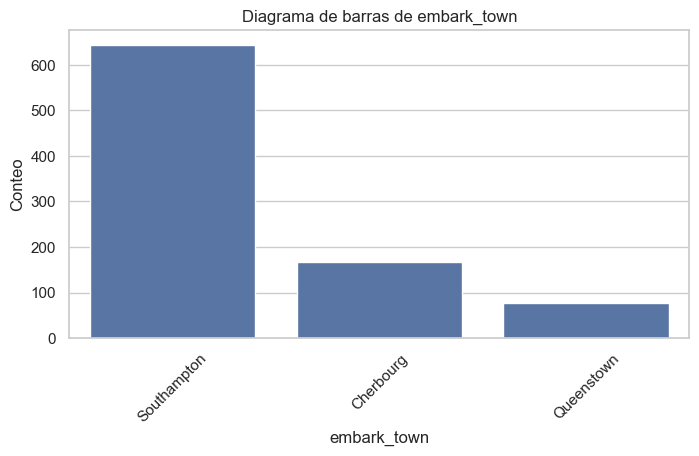

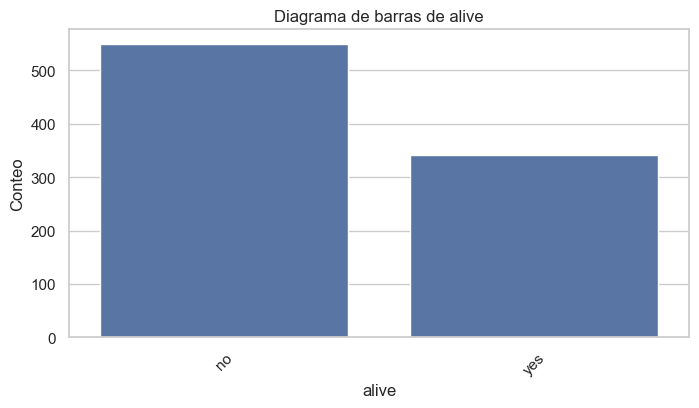

In [91]:
#7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.



numeric_columns = df.select_dtypes(include=['int', 'float']).columns.tolist()
sns.set(style="whitegrid")
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()


categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Diagrama de barras de {col}')
    plt.xlabel(col)
    plt.ylabel('Conteo')
    plt.xticks(rotation=45)
    plt.show()


In [84]:
#8. Trata las variables para que funcionen lo mejor posible en el modelo.


In [85]:
#9. Construye un modelo de regresión logística.


In [87]:
#11. Procesa el dataset de Test para que puedas usarlo en la evaluación 


In [88]:
#12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
